In this notebook we will train a Variational Auto-Encoder VAE, which will (hopefully) translate all UI images into some n-dimensional space, in which we can then do the optimising.

We will use [https://github.com/AntixK/PyTorch-VAE](https://github.com/AntixK/PyTorch-VAE/tree/master) as a basis.

In [1]:
!nvidia-smi

Tue Jun 18 08:23:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:81:00.0 Off |                    0 |
| N/A   34C    P0              54W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
from os import listdir
from os.path import isfile, join
import json
from utils import calculate_initial_theta, stack_alpha_aware, transform_to_t
import utils
from math import prod
from loguru import logger
import matplotlib.pyplot as plt
import torch
from PIL import Image
import random

Tensor = TypeVar('torch.tensor')

In [3]:
import torchvision.transforms as T
from torchvision import datasets, transforms
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])

In [4]:
from torch import nn
from torch.utils.data import Dataset
from abc import abstractmethod

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError
    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

Proposed in_channels:

Almost all UIs will have 3 Buttons and 3 `FIXME` objects. So we will input an ordered list into it of the respective normalised (between 0 and 1) positions.

In [5]:
def get_all_clickable_resources(item, should_be_clickable):
    if item is None:
        return []
    all_boxes = []
    if "bounds" in item.keys() and "resource-id" in item.keys() and "clickable" in item.keys() and item["clickable"]==should_be_clickable and item["visible-to-user"]:
        all_boxes.append((item["bounds"],item["resource-id"]))
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_clickable_resources(child,should_be_clickable):
                all_boxes.append(box)
    return all_boxes

def get_all_bounding_boxes(item, should_be_clickable):
    bboxes = get_all_clickable_resources(item,should_be_clickable)
    reduced_bboxes = []
    already_seen_ids = []
    for box,r_id in bboxes:
        if r_id not in already_seen_ids:
            reduced_bboxes.append(box)
            already_seen_ids.append(r_id)
    return reduced_bboxes


In [6]:
NORMAL_UI_DIMENSIONS = (1440, 2560)

def combine_list_of_lists(a,b):
    assert len(a) == len(b)
    lol = []
    for x in range(len(a)):
        assert len(a[x]) == len(a[x])
        i = []
        for h in range(len(a[x])):
            i.append(a[x][h])
        for h in range(len(b[x])):
            i.append(b[x][h])
        lol.append(i)
    return lol

class CustomRicoDataset(Dataset):
    def __init__(self, combined_path="./combined", return_metadata=False, forward_to_next_index_on_error=False):
        self.image_files = [
            f
            for f in listdir(combined_path)
            if isfile(join(combined_path, f)) and ("jpg" in f or "jpeg" in f)
        ]
        self.combined_path = combined_path
        self.return_metadata = return_metadata
        self.forward_to_next_index_on_error = forward_to_next_index_on_error

        self.get_first_n_clickable = 4
        self.get_first_n_non_clickable = 3

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = join(self.combined_path,self.image_files[idx])
        image = Image.open(img_path)

        json_path = join(self.combined_path,self.image_files[idx].split(".")[0]+".json")
        with open(json_path, "r") as f:
            image_json = json.load(f)

        
        if not self.forward_to_next_index_on_error:
            clickable_elems = utils.get_first_n_sorted_elements(image, image_json, self.get_first_n_clickable, True)
            non_clickable_elems = utils.get_first_n_sorted_elements(image, image_json, self.get_first_n_non_clickable, False)
        else:
            try:
                clickable_elems = utils.get_first_n_sorted_elements(image, image_json, self.get_first_n_clickable, True)
                non_clickable_elems = utils.get_first_n_sorted_elements(image, image_json, self.get_first_n_non_clickable, False)
            except ValueError:
                if idx == (len(self)-1):
                    return self[idx-100]
                return self[idx+1]
                
        combined_elems = combine_list_of_lists(clickable_elems, non_clickable_elems)
        
        if self.return_metadata:
            return [combined_elems[0], torch.tensor(combined_elems[1]).unsqueeze(0), combined_elems[2]], img_path
        else:
            return torch.tensor(combined_elems[1]).unsqueeze(0)

In [7]:
dataset = CustomRicoDataset("../combined", forward_to_next_index_on_error=True)

In [8]:
if False:
    okay_points = 0
    not_okay_points = 0
    indexes = list(range(len(dataset)))
    random.shuffle(indexes)
    for x in tqdm(indexes):
        try:
            _ = dataset[sample_idx]
            okay_points += 1
        except ValueError:
            print(f"{x}: Not okay")
            not_okay_points += 1
    okay_points, not_okay_points        

In [9]:
sample_idx = torch.randint(len(dataset), size=(1,)).item()
j = dataset[sample_idx]

In [10]:
j.shape

torch.Size([1, 7, 2])

In [11]:
import torch
# from models import BaseVAE
from torch import nn
from torch.nn import functional as F
# from .types_ import *


class VanillaVAE(BaseVAE):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        # Number of elems that have been chosen previously
        self.n_elems = 7

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    #nn.Conv2d(in_channels, out_channels=h_dim,
                    #          kernel_size= 3, stride= 2, padding  = 1),
                    nn.Linear(in_channels, h_dim),
                    # nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*self.n_elems, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*self.n_elems, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * self.n_elems)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    #nn.ConvTranspose2d(hidden_dims[i],
                    #                   hidden_dims[i + 1],
                    #                   kernel_size=3,
                    #                   stride = 2,
                    #                   padding=1,
                    #                   output_padding=1),
                    #nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            #nn.ConvTranspose2d(hidden_dims[-1],
                            #                   hidden_dims[-1],
                            #                   kernel_size=3,
                            #                   stride=2,
                            #                   padding=1,
                            #                   output_padding=1),
                            #nn.BatchNorm2d(hidden_dims[-1]),
                            nn.Linear(hidden_dims[-1],hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Linear(hidden_dims[-1],2),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, self.n_elems, 512)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [12]:
vae = VanillaVAE(in_channels=2, latent_dim=32)

In [13]:
recons, inp, mu, log_var = vae.forward(j)

In [14]:
loss = vae.loss_function(recons,inp,mu,log_var, M_N=1)

In [15]:
loss

{'loss': tensor(0.3080, grad_fn=<AddBackward0>),
 'Reconstruction_Loss': tensor(0.2965),
 'KLD': tensor(-0.0115)}

In [16]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from accelerate import Accelerator

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [17]:
accelerator = Accelerator()

In [18]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25, verbose = True)

In [19]:
vae, optimizer, train_dataloader, scheduler = accelerator.prepare(vae, optimizer, train_dataloader, scheduler)

In [20]:
vae

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=3584, out_features=32, bias=True)
  (fc_var): Linear(in_features=3584, out_features=32, bias=True)
  (decoder_input): Linear(in_features=32, out_features=3584, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=256, 

In [21]:
force_retrain = False
losses = []
if not isfile("./vae_pretrained") or force_retrain:
    for batch in tqdm(train_dataloader):
        # j_tensor = .to(accelerate)
        # print(batch)
        recons, inp, mu, log_var = vae.forward(batch)
        loss = vae.loss_function(recons,inp,mu,log_var, M_N=64)
        # loss["loss"].backward()
        
        accelerator.backward(loss["loss"])
    
        torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.5)
    
        
        optimizer.step()
        
        # logger.info(f"{loss['loss'].item()}, lr: {scheduler.get_last_lr()[0]}")
        logger.info(f"{loss['loss'].item()}")
        losses.append(loss["loss"].detach().cpu().item())
        scheduler.step(loss["loss"])
    torch.save(vae.state_dict(), "./vae_pretrained")
else:
    vae.load_state_dict(torch.load("./vae_pretrained"))
    vae.eval()

In [22]:
if losses:
    plt.plot(losses[50:])
    plt.show()

In [23]:
if losses:
    print(losses[-1])

In [24]:
dataset[0].shape

torch.Size([1, 7, 2])

In [25]:
recons, inp, mu, log_var = vae.forward(dataset[100].to(accelerator.device))
z = vae.reparameterize(mu, log_var)

In [26]:
inp

tensor([[[1.0000, 0.0602],
         [0.7056, 0.0602],
         [0.8396, 0.0355],
         [0.1556, 0.0574],
         [1.0000, 0.0656],
         [0.9514, 0.0480],
         [1.0000, 0.0328]]], device='cuda:0')

In [27]:
recons

tensor([[[0.7498, 0.1173],
         [0.5016, 0.0927],
         [0.3815, 0.0786],
         [0.3075, 0.0704],
         [0.9242, 0.1410],
         [0.8715, 0.1364],
         [0.7498, 0.1141]]], device='cuda:0', grad_fn=<TanhBackward0>)

In [28]:
z

tensor([[-0.7549, -0.3373, -0.5193, -1.1020, -0.2749, -0.7924, -0.5143,  2.1247,
         -0.3573, -0.3933,  0.3057,  1.4382,  0.3134,  0.7210, -0.2694, -0.0329,
         -0.2266,  0.4473,  0.6622, -0.2041,  0.9589,  0.4919, -0.0868, -0.3143,
          0.2841, -0.9153,  0.3654,  0.1713,  0.1029, -0.5175,  1.4769,  1.3853]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [29]:
# We need to modify this function to avoid np conversions and differentiation problems
def calculate_initial_theta(segment, canvas_size, original_position):
    # Theta consists of 6 values, 4 of which we have to calculate.
    x_ratio = canvas_size[0] / segment.size[0]
    y_ratio = canvas_size[1] / segment.size[1]
    # grid_location_x and grid_location_y are basically percentages of height and width and not actual coordinates
    # Because we already warp the segment onto a bigger canvas, this transformation is a bit complicated
    # grid_location_x has to be in the interval [-(x_ratio-1),(x_ratio-1)], i.e. 0 means -(x_ratio - 1) and 1440 means (x_ratio - 1)
    # We can map U ~ [0, 1] to U ~ [a, b] with u -> (a - b)*u + b
    # We first map U ~ [0, max_width] to U ~ [0,1] by dividing by max_width

    eps = 0.00001 # Avoid div by zero
    original_x_position = (original_position[0]) / (canvas_size[0]-segment.size[0]+eps)
    mapped_x_position = (-(x_ratio - 1) - (x_ratio - 1))*original_x_position + (x_ratio-1)

    original_y_position = (original_position[1]) / (canvas_size[1]-segment.size[1]+eps)
    mapped_y_position = (-(y_ratio - 1) - (y_ratio - 1))*original_y_position + (y_ratio-1)

    theta = torch.tensor([
        [0.0,0.0,0.0],
        [0.0,0.0,0.0]
    ]).to(accelerator.device)
    
    theta[0][0] += x_ratio
    theta[1][1] += y_ratio
    theta[0][2] += mapped_x_position
    theta[1][2] += mapped_y_position
    
    #return np.array([
    #    [x_ratio, 0.0    , mapped_x_position],
    #    [0.0    , y_ratio, mapped_y_position]
    #])
    return theta

In [30]:
class MultivariateNormalPDF(nn.Module):
    def __init__(self, mean, covariance, device):
        super(MultivariateNormalPDF, self).__init__()
        self.mean = mean.to(device)
        self.covariance = covariance.to(device)
        self.inv_covariance = torch.inverse(covariance).to(device)
        self.det_covariance = torch.det(covariance).to(device)
        self.dim = mean.size(0)
        self.const = torch.sqrt((2 * torch.pi) ** self.dim * self.det_covariance).to(device)
    
    def forward(self, x):
        diff = x - self.mean
        exp_term = -0.5 * torch.sum(diff @ self.inv_covariance * diff, dim=1)
        return torch.exp(exp_term) / self.const

class MultivariateNormalLoss(nn.Module):
    def __init__(self, mean, covariance, device="cpu"):
        super(MultivariateNormalLoss, self).__init__()
        self.pdf = MultivariateNormalPDF(mean, covariance,device)
        self.pdf = self.pdf.to(device)
    
    def forward(self, x):
        pdf_values = self.pdf(x)
        print(pdf_values)
        nll = -torch.log(pdf_values + 1e-8)  # Adding epsilon to prevent log(0)
        print(nll)
        return nll.mean()

from torch.distributions import MultivariateNormal
def multivariate_normal_pdf(x, mean, cov):
    dist = MultivariateNormal(loc=mean, covariance_matrix=cov)
    # return log prob for numerical stability
    return -dist.log_prob(x)
    # return torch.exp(dist.log_prob(x)) 

In [31]:
class GradientDescent(torch.nn.Module):
    def __init__(self, vae, z, segments, aesthetics_predictor, device):
        super().__init__()
        self.vae = vae
        self.z = torch.nn.Parameter(z.to(device))
        self.vae = self.vae.eval().to(device)
        self.segments = segments
        self.device = device
        self.aesthetics_predictor = aesthetics_predictor.to(self.device)
        
        self.canvas_size = (1,3,NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0])
        self.mean = torch.zeros(self.z.shape[1]).to(self.device)
        print(f"Mean shape: {self.mean.shape}")
        self.cov = torch.eye(z.shape[1]).to(self.device)
        print(f"Cov shape: {self.cov.shape}")
        # self.mn_loss = MultivariateNormalLoss(self.mean, self.cov, self.device)
        self.mn_loss = lambda x: multivariate_normal_pdf(x, self.mean, self.cov)

    def forward(self):
        decoded = self.vae.decode(self.z)
        decoded_denormalised = decoded * torch.tensor([NORMAL_UI_DIMENSIONS[0],NORMAL_UI_DIMENSIONS[1]]).to(self.device)
        segments_on_canvas = []
        
        for n in range(len(self.segments)):
            theta = calculate_initial_theta(self.segments[n],NORMAL_UI_DIMENSIONS,decoded_denormalised[0][n]) 
            theta = theta.unsqueeze(0).to(self.device)

            if self.device == "cpu":
                grid = F.affine_grid(theta, self.canvas_size).type(torch.FloatTensor)
            else:
                grid = F.affine_grid(theta, self.canvas_size).type(torch.FloatTensor).to(self.device)
            x = F.grid_sample(transform_to_t(self.segments[n]).unsqueeze(0).to(self.device), grid)
            segments_on_canvas.append(x)

        generated_image = stack_alpha_aware(segments_on_canvas)
        generated_image = generated_image[:3]

        score = self.aesthetics_predictor(generated_image.unsqueeze(0))

        mn_loss = self.mn_loss(self.z)
            
        return score, generated_image, mn_loss

In [32]:
test_dataset = CustomRicoDataset("../combined", return_metadata=True, forward_to_next_index_on_error=True)

In [33]:
test_dataset.image_files[0]

'70987.jpg'

In [34]:
dataset_index = 10291

In [35]:
[bboxes, normalized_positions, segments], path = test_dataset[dataset_index]

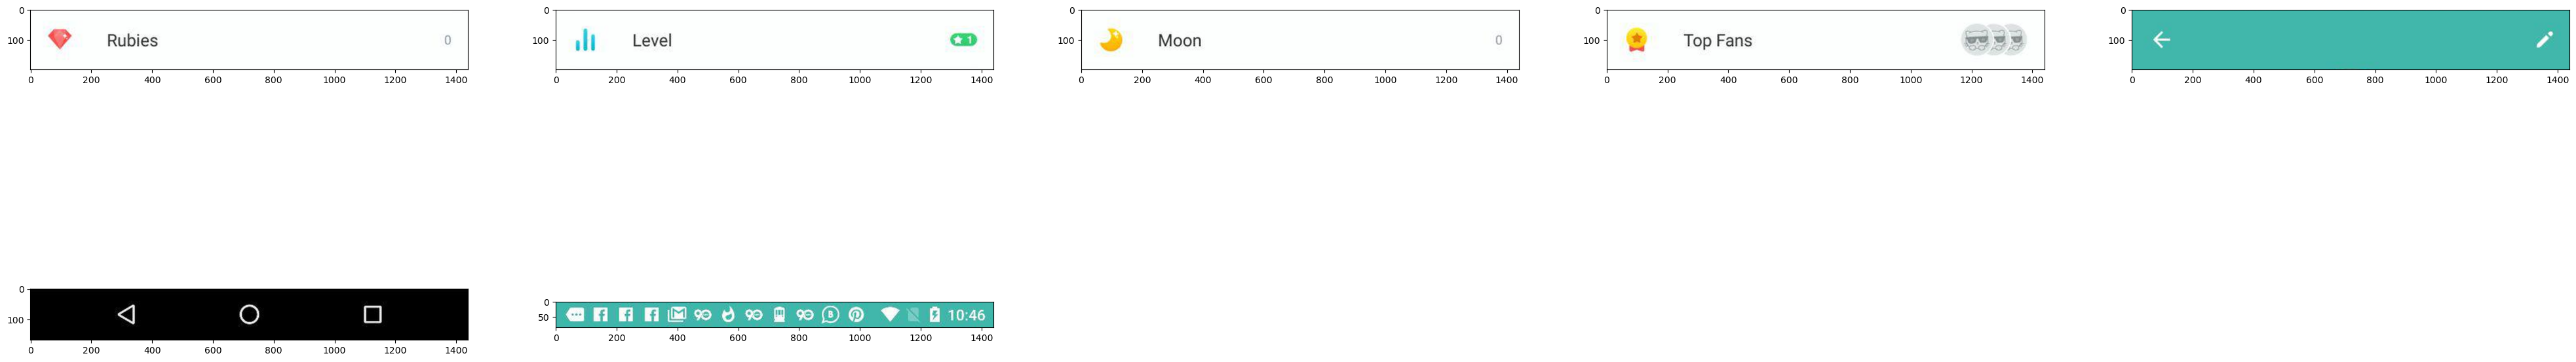

In [36]:
fig = plt.figure(figsize=(50,10))
a = 1
for i in segments:
    fig.add_subplot(2,5,a)
    plt.imshow(i)
    a+=1
plt.show()

In [37]:
appsthetics_predictor = torch.load("../Dataset_estetica/Regressao/model123")

In [39]:
mu, log_var = vae.encode(normalized_positions.to("cuda"))
z = vae.reparameterize(mu, log_var)
gd = GradientDescent(vae, z, segments, appsthetics_predictor["model"], "cpu")

Mean shape: torch.Size([32])
Cov shape: torch.Size([32, 32])


In [40]:
mean = torch.tensor([0.0]*z.shape[1])
cov = torch.tensor([1.0]*z.shape[1])
covariance = torch.diag(cov)
# loss_fn = MultivariateNormalLoss(mean, covariance, accelerator.device)

In [41]:
pdf = multivariate_normal_pdf(z.to("cpu"), mean, covariance)
print(pdf)
# Negative log-likelihood as loss (smaller PDF, higher loss)
# -torch.mean(torch.log(pdf))

tensor([51.0185], grad_fn=<NegBackward0>)


In [42]:
pdf

tensor([51.0185], grad_fn=<NegBackward0>)

In [43]:
# loss = loss_fn(z)

In [44]:
# loss

/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


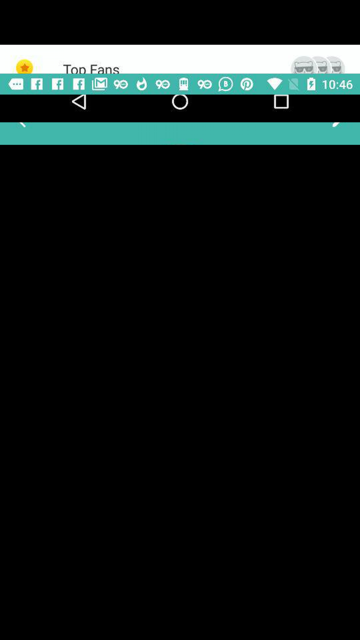

In [45]:
score, img, mn_loss = gd.forward()
result_pil_before = transform_t_to_pil(img)
display(result_pil_before.resize((int(result_pil_before.size[0]*0.25),int(result_pil_before.size[1]*0.25))))

In [48]:
scores = []
optimiser_gd = torch.optim.AdamW(gd.parameters(),lr=0.005)
for x in range(5):
    score, image, mn_loss = gd.forward()
    score = score[0][0]
    loss = -score
    loss += mn_loss[0] / 100.0
    print(f"aesthetics score: {score}, mn_loss: {mn_loss}(/100), sum: {loss}")
    loss.backward()
    scores.append(loss.item())
    optimiser_gd.step()

aesthetics score: 0.5410243272781372, mn_loss: tensor([51.0185], grad_fn=<NegBackward0>), sum: -0.03083956241607666
aesthetics score: 1.9438821077346802, mn_loss: tensor([50.9605], grad_fn=<NegBackward0>), sum: -1.434276819229126
aesthetics score: 1.665343999862671, mn_loss: tensor([50.8531], grad_fn=<NegBackward0>), sum: -1.1568129062652588
aesthetics score: 26.166950225830078, mn_loss: tensor([50.7398], grad_fn=<NegBackward0>), sum: -25.6595516204834
aesthetics score: 289.78228759765625, mn_loss: tensor([50.7008], grad_fn=<NegBackward0>), sum: -289.2752685546875


In [49]:
score, img, pdf_loss = gd.forward()

In [50]:
score.item(), pdf_loss.item()

(1970.8167724609375, 50.61406707763672)

In [51]:
# display(result_pil_after.resize((int(result_pil_after.size[0]*0.25),int(result_pil_after.size[1]*0.25))))

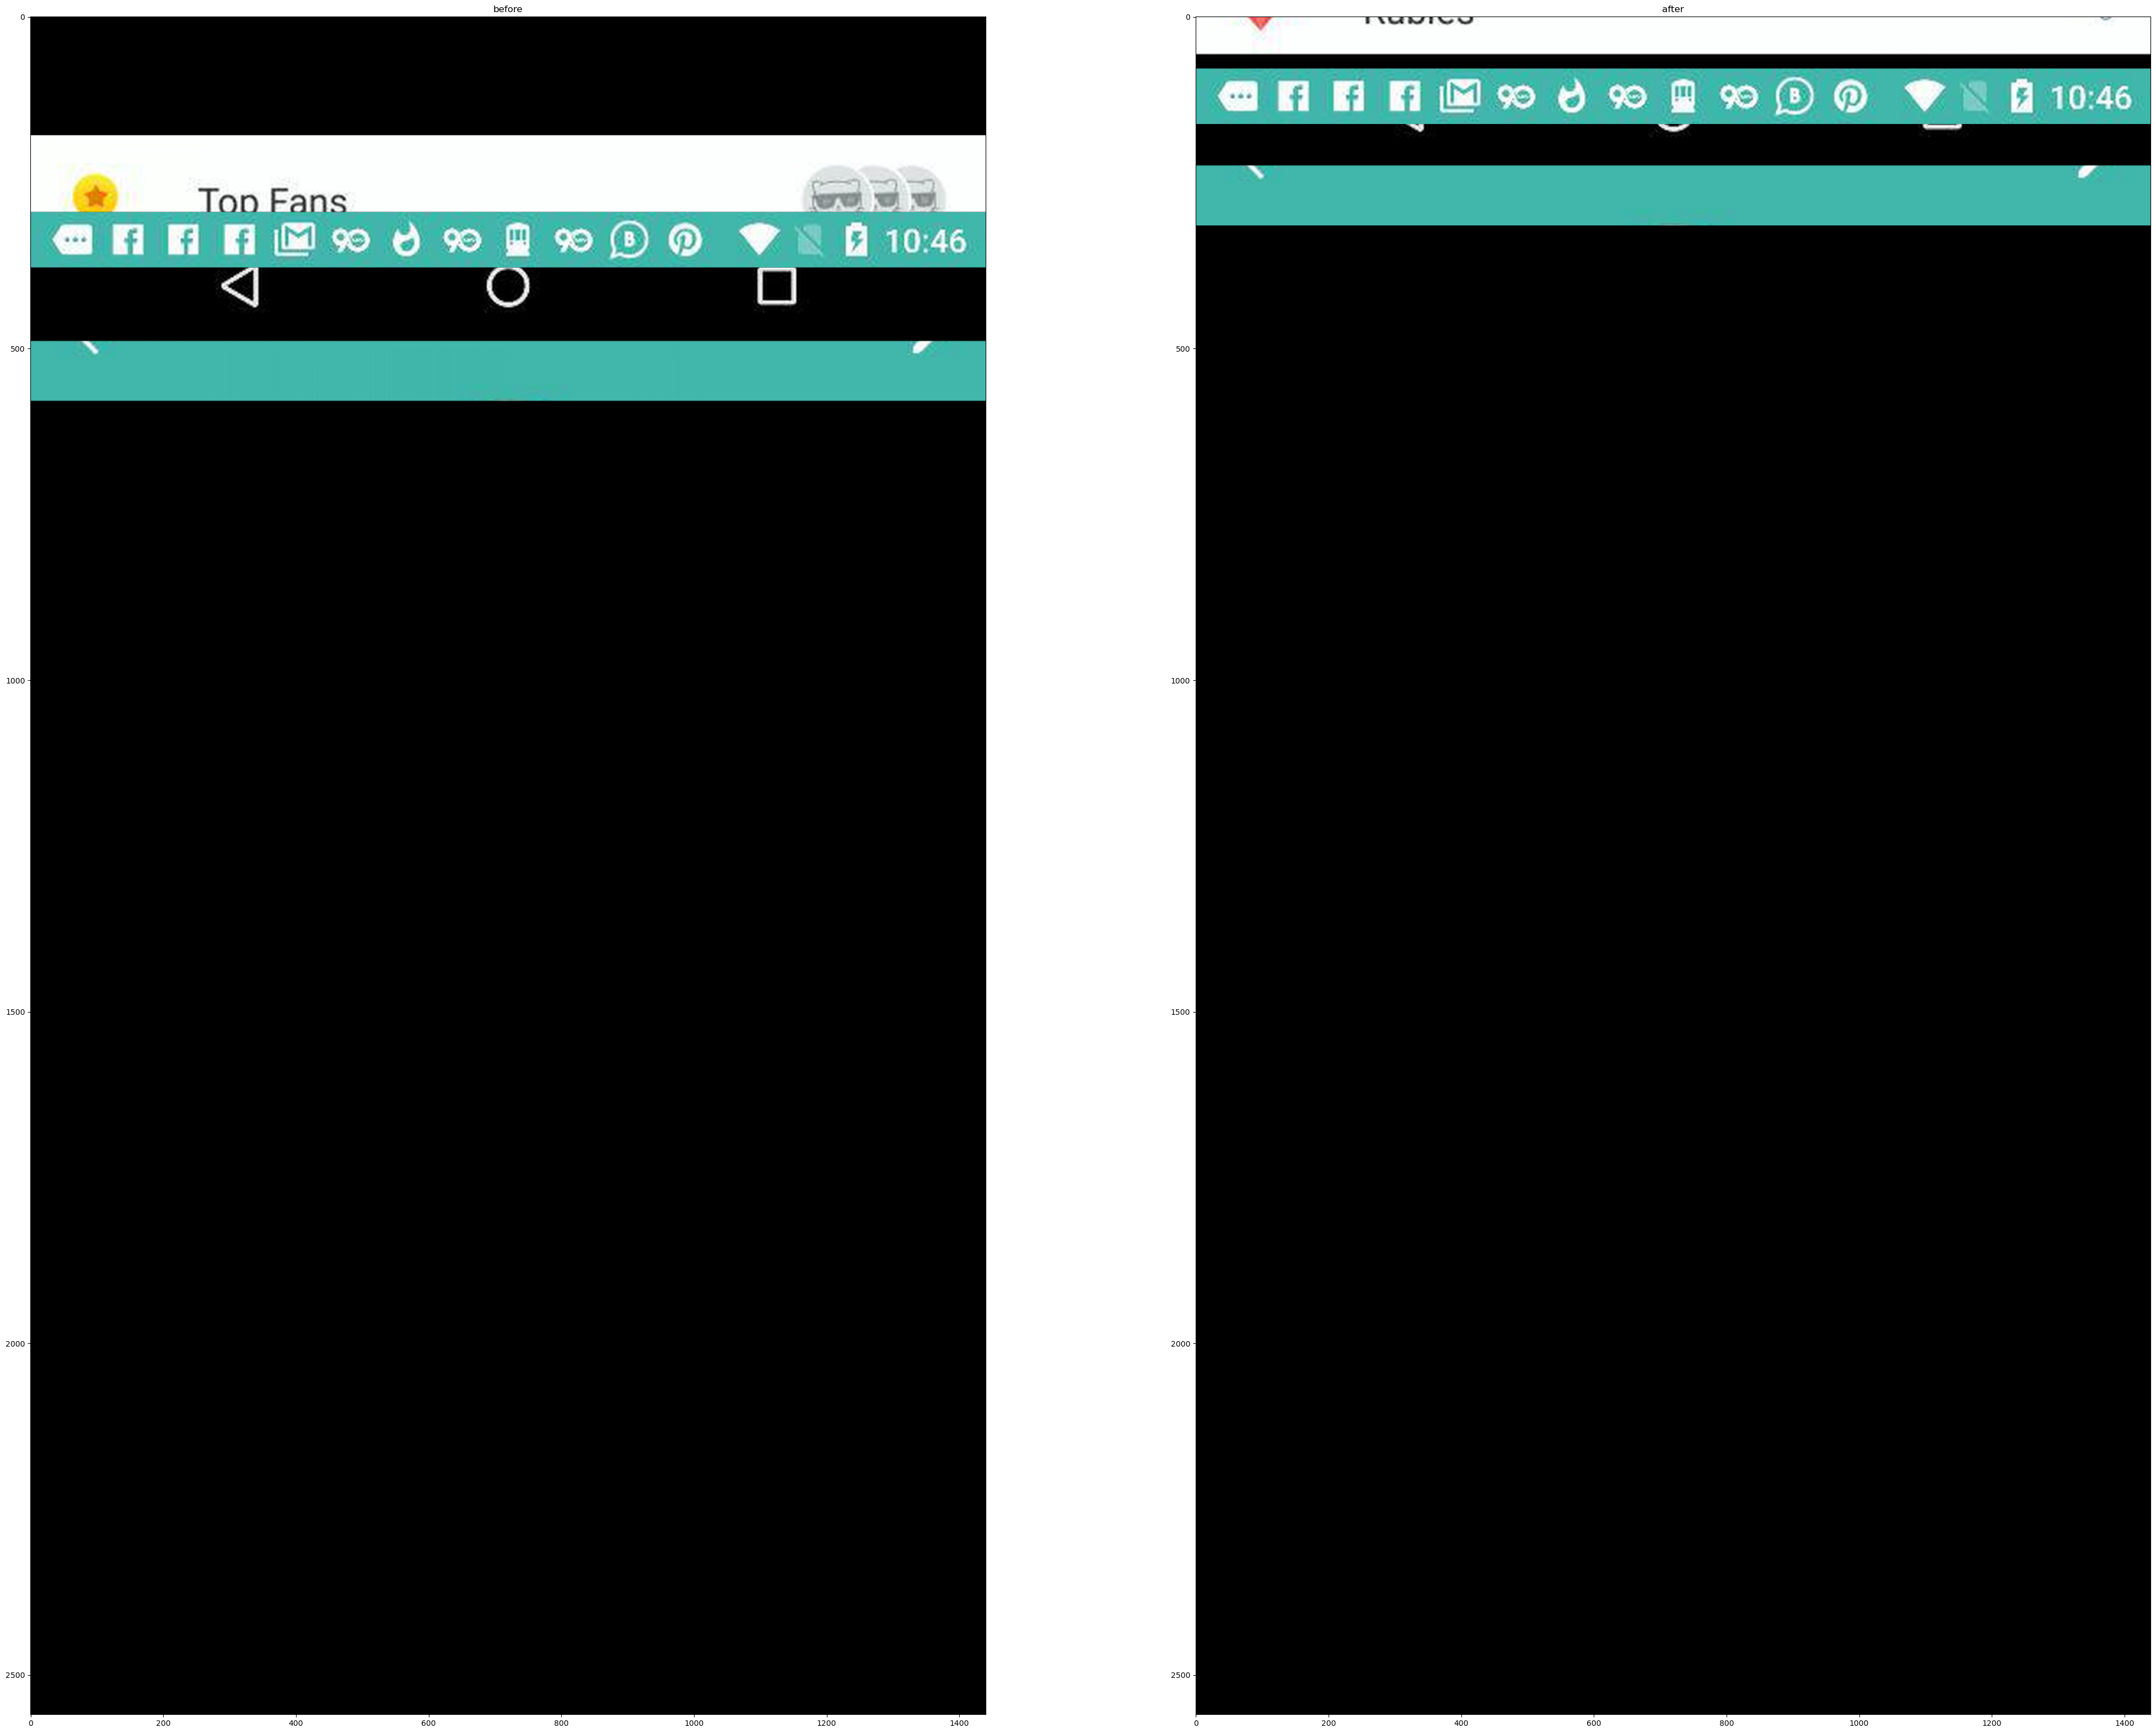

In [52]:
result_pil_after = transform_t_to_pil(img)
fig = plt.figure(figsize=(50,40))
fig.add_subplot(1,2,1)
plt.imshow(result_pil_before)
plt.title("before")
fig.add_subplot(1,2,2)
plt.imshow(result_pil_after)
plt.title("after")
plt.show()

In [53]:
decoded = gd.vae.decode(gd.z)
decoded_denormalised = decoded * torch.tensor([NORMAL_UI_DIMENSIONS[0],NORMAL_UI_DIMENSIONS[1]])
decoded_denormalised

tensor([[[ 652.5903, -109.0037],
         [ 296.9263,  113.6941],
         [ 366.1942,   58.9639],
         [ 394.1773,   83.9889],
         [ 300.4856,  119.1283],
         [ 371.2820,   56.4774],
         [ 431.2336,   78.1927]]], grad_fn=<MulBackward0>)

In [54]:
gd.z

Parameter containing:
tensor([[ 0.7053,  2.1513, -1.2721, -2.6237, -0.4515,  1.5247, -0.5381,  1.7509,
          0.6389, -1.0249, -0.0308, -1.3809, -0.5285,  1.4035,  0.7303,  0.7343,
         -0.0703, -1.5839, -0.6425,  0.9119,  0.5551,  1.1737, -1.4557, -0.3956,
         -0.6319,  1.2122,  1.0787,  1.7541,  0.8748,  1.0867,  0.3179, -0.5837]],
       requires_grad=True)